## Classification models comparison

Inspired by https://www.kaggle.com/datafan07/heart-disease-and-some-scikit-learn-magic#Modelling  

In [17]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [18]:
data_dir = Path('../data/raw/')
heart_csv = data_dir / 'heart.csv'
heart_df = pd.read_csv(heart_csv)
nrows, ncols = heart_df.shape

print('Dataset has {} rows and {} columns'.format(nrows, ncols))

heart_df.sample(5)

Dataset has 303 rows and 14 columns


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1,0
228,59,1,3,170,288,0,0,159,0,0.2,1,0,3,0
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3,1
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1


In [19]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continuous = list(set(heart_df.columns.tolist()).difference(set(categorical + ['target'])))

print('Categorical', categorical)
print('Numerical', continuous)

Categorical ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Numerical ['oldpeak', 'age', 'chol', 'thalach', 'trestbps']


In [20]:
X = heart_df.drop('target', axis=1)
y = heart_df['target']

In [21]:
dummies = pd.get_dummies(data=X[categorical])
X.drop(categorical, axis=1, inplace=True)
X = pd.concat([X, dummies], axis=1)

### Models

In [11]:
from sklearn.model_selection import cross_validate, KFold, learning_curve,  cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix

In [12]:
gradclass = GradientBoostingClassifier(random_state=seed)
knclass = KNeighborsClassifier()
dectree = DecisionTreeClassifier(random_state=seed)
svc = SVC()
randfclass = RandomForestClassifier(random_state=seed)
adaclass = AdaBoostClassifier(random_state=seed)
mlpclass = MLPClassifier(random_state=seed)
gsclass = GaussianNB()

In [13]:
cv = KFold(5, shuffle=True, random_state=seed)
classifiers = [gradclass, knclass, dectree, svc, randfclass, adaclass, mlpclass, gsclass]

In [25]:
def model_check(X, y, classifiers, cv):
    
    ''' A function for testing multiple classifiers and return several metrics. '''
    
    model_table = pd.DataFrame()

    row_index = 0
    for cls in classifiers:

        MLA_name = cls.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        
        cv_results = cross_validate(
            cls,
            X,
            y,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True,
            n_jobs=-1
        )
        model_table.loc[row_index, 'Train Roc/AUC Mean'] = cv_results['train_roc_auc'].mean()
        model_table.loc[row_index, 'Test Roc/AUC Mean'] = cv_results['test_roc_auc'].mean()
        model_table.loc[row_index, 'Test Roc/AUC Std'] = cv_results['test_roc_auc'].std()
        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_accuracy'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()
        model_table.loc[row_index, 'Test Acc Std'] = cv_results['test_accuracy'].std()
        model_table.loc[row_index, 'Train F1 Mean'] = cv_results['train_f1'].mean()
        model_table.loc[row_index, 'Test F1 Mean'] = cv_results['test_f1'].mean()
        model_table.loc[row_index, 'Test F1 Std'] = cv_results['test_f1'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1        

    model_table.sort_values(by=['Test F1 Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

def f_imp(classifiers, X, y, bins):
    
    ''' A function for displaying feature importances'''
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):

        try:
            classifier.fit(X, y)
            feature_imp = pd.DataFrame(sorted(
                zip(classifier.feature_importances_, X.columns)),
                                       columns=['Value', 'Feature'])

            sns.barplot(x="Value",
                        y="Feature",
                        data=feature_imp.sort_values(by="Value",
                                                     ascending=False),
                        ax=ax,
                        palette='plasma')
            plt.title('Features')
            plt.tight_layout()
            ax.set(title=f'{classifier.__class__.__name__} Feature Impotances')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))
        except:
            continue
    plt.show()

In [27]:
raw_models = model_check(X, y, classifiers, cv) # todo: normalization ?
display(raw_models)

,Model Name,Train Roc/AUC Mean,Test Roc/AUC Mean,Test Roc/AUC Std,Train Accuracy Mean,Test Accuracy Mean,Test Acc Std,Train F1 Mean,Test F1 Mean,Test F1 Std,Time
6,MLPClassifier,0.924884,0.875017,0.035322,0.849005,0.825027,0.041562,0.866120,0.844936,0.040777,0.156986
4,RandomForestClassifier,1.000000,0.902932,0.032124,1.000000,0.815137,0.032370,1.000000,0.836166,0.019382,0.105815
7,GaussianNB,0.912074,0.892448,0.026182,0.841557,0.808142,0.062952,0.859033,0.828544,0.047553,0.002750
0,GradientBoostingClassifier,0.999836,0.885948,0.029338,0.997527,0.801913,0.035075,0.997758,0.820464,0.033728,0.081608
5,AdaBoostClassifier,0.986764,0.851129,0.042228,0.933180,0.795301,0.025444,0.939065,0.815854,0.021119,0.053376
2,DecisionTreeClassifier,1.000000,0.775911,0.027723,1.000000,0.775683,0.025906,1.000000,0.787744,0.012341,0.003222
3,SVC,0.760355,0.732430,0.105705,0.663368,0.663060,0.072222,0.729288,0.726213,0.061057,0.003967
1,KNeighborsClassifier,0.845273,0.717684,0.051642,0.769782,0.670000,0.064265,0.793337,0.705238,0.067106,0.002895


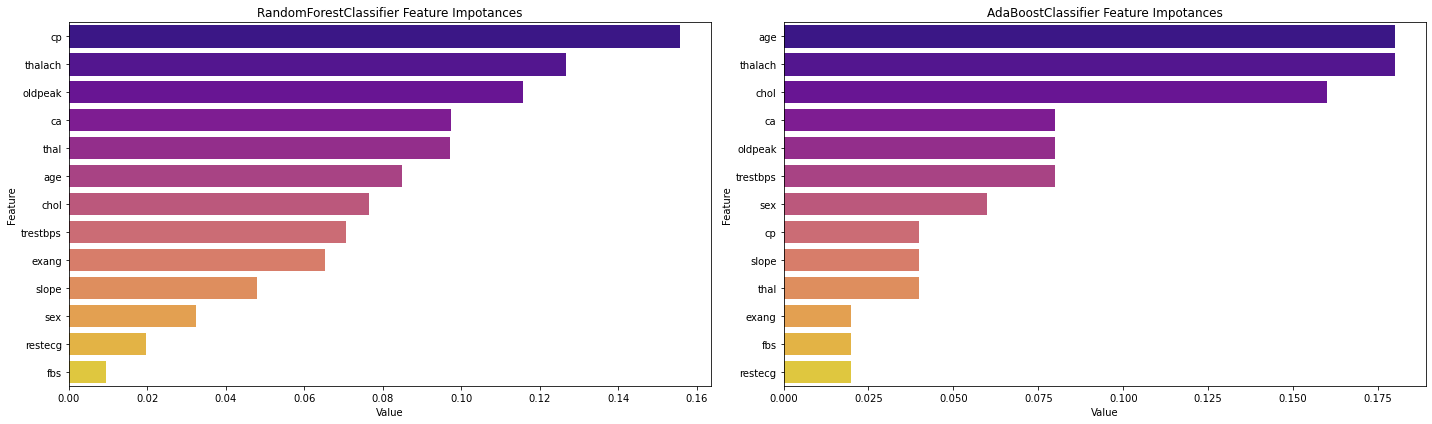

In [30]:
f_imp([randfclass, adaclass], X, y, 6)

Best models are `MLPClassifier` and `RandomForestClassifier`

In [44]:
sampled = X.sample(30).reset_index()
sampled= sampled.drop(['index'], axis=1)

In [46]:
sampled.to_csv('../data/inference.csv', index=None)

In [45]:
sampled

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
0,69,140,254,146,2.0,1,2,0,0,0,1,3,3
1,49,134,271,162,0.0,0,1,0,1,0,1,0,2
2,48,130,256,150,0.0,1,0,1,0,1,2,2,3
3,57,120,354,163,0.6,0,0,0,1,1,2,0,2
4,51,140,299,173,1.6,1,0,0,1,1,2,0,3
5,46,142,177,160,1.4,0,2,0,0,1,0,0,2
6,43,150,247,171,1.5,1,0,0,1,0,2,0,2
7,71,112,149,125,1.6,0,0,0,1,0,1,0,2
8,55,135,250,161,1.4,0,1,0,0,0,1,0,2
9,59,140,177,162,0.0,1,0,0,1,1,2,1,3
